In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import neurkal

import itertools
from matplotlib import pyplot as plt
from matplotlib import rc, rcParams
import numpy as np
import seaborn as sns

In [26]:
# make Numpy raise warnings as exceptions (or not)
np.seterr(all='warn')
#np.seterr(all='raise')

{'divide': 'raise', 'invalid': 'raise', 'over': 'raise', 'under': 'raise'}

In [3]:
## Plot style setup
#rc('mathtext', default='regular')
#rcParams.update({'figure.autolayout': True})
sns.set_style("ticks")
#set_palette = lambda: itertools.cycle(sns.color_palette("cubehelix", 8))
set_palette = lambda: itertools.cycle(sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95, reverse=True))

In [205]:
def input_act(x, x_i):
    return 3 * (np.exp(2 * (np.cos(np.deg2rad(x - x_i)) - 1)) + 0.01)

In [206]:
# dynamical parameters
M = [[1]]  # internal model dynamics
B = [[0.003]]   # constant "motor" dynamics
Z = [[0.0001]]  # motor noise variance
c = 1
c_ = np.array([[c]])

In [210]:
# simulation parameters
p = 20  # units in input networks
th_r = [-180, 180]
d_th = [1, 2]
steps = int(np.diff(d_th) / B[0][0])  # number of timesteps
t_f = 100
ts = np.linspace(0, t_f, steps)

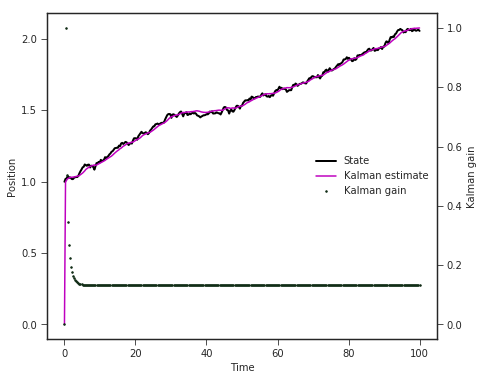

In [208]:
## test conventional kalman filter
kalman = neurkal.KalmanFilter(M=M, B=B, Z=Z)
# initial state
state = neurkal.StateDynamics(M, B, Z, x0=d_th[0])
# sensory noise
sensory_variance = 0.005

states = []
estimates = []
gains = []
for t in ts:
    estimates.append(kalman.estimate[0, 0])
    gains.append(kalman.gain[0, 0])
    states.append(state.x[0])
    x_s = state.x + np.random.normal(0, sensory_variance)
    kalman.step(c_, x_s, Q=[[sensory_variance]])
    state.update(c_)

palette = set_palette()
fig, ax1 = plt.subplots(figsize=(7, 6))
ax1.set_xlabel("Time")
ax1.set_ylabel("Position")
p1, = ax1.plot(ts, states, '-', color=next(palette), label="State", lw=2)
p2, = ax1.plot(ts, estimates, '-', color='m', label="Kalman estimate", markerfacecolor='none', ms=8)
ax2 = ax1.twinx()
ax2.set_ylabel("Kalman gain")
p3, = ax2.plot(ts, gains, '.', color=next(palette), label="Kalman gain", ms=3)

ps = [p1, p2, p3]
labels = [p.get_label() for p in ps]
ax1.legend(ps, labels, loc=7)
plt.show()

/home/matthew/dev/neurkal/neurkal/neurkal.py:198: RuntimeWarning: underflow encountered in square
  self._u_den = self._mu + self._eta * np.sum(self._u ** 2)
/home/matthew/dev/neurkal/neurkal/neurkal.py:190: RuntimeWarning: underflow encountered in double_scalars
  self._h[i] = (self._u[i] ** 2) / self._u_den


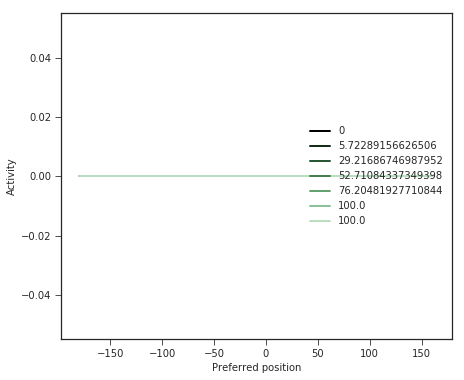

In [218]:
## Kalman network test -- only initial feedback
# initial state
state = neurkal.StateDynamics(M, B, Z, x0=d_th[0])

# network initialization
sensory_input = neurkal.PopCode(p, space=th_r, act_func=input_act,
                                dist=np.random.poisson)
# motor_input = popcode.PopCode(p, act_func=input_act, dist=lambda x: x)
kalman_network = neurkal.KalmanBasisNetwork(sensory_inputs=[sensory_input],
                                            motor_inputs=[], M=M, B=B)

activities = []
states = []

sensory_input(state.x[0])
for t in ts:
    activities.append(np.copy(kalman_network.activity))
    states.append(state.x[0])
    # update activity in basis network implementing Kalman filter
    sigma = np.var(estimates[-10:]) if i > 10 else 1e12
    kalman_network.update([[sigma]])
    # update real state (+ control noise)
    state.update(c_)
    if not t:
        sensory_input.clear()

prefs = kalman_network.prefs
    
palette = set_palette()
fig, ax1 = plt.subplots(figsize=(7, 6))
ax1.set_xlabel("Preferred position")
ax1.set_ylabel("Activity")
plots = 5
ps = []
ps.append(ax1.plot(prefs, activities[0], '-', color=next(palette), lw=2, label="0")[0])
for i in np.linspace(ts[plot_step], len(ts) - 1, plots).tolist():
    ps.append(ax1.plot(prefs, activities[int(i)], '-', color=next(palette), lw=2, 
                       label=str(ts[int(i)]))[0])
ps.append(ax1.plot(prefs, activities[-1], '-', color=next(palette), lw=2, label=str(ts[-1]))[0])
    
labels = [p.get_label() for p in ps]
ax1.legend(ps, labels, loc=7)
plt.show()

0.015015015015015015

In [193]:
np.linspace(ts[plot_step], len(ts) - 1, plot_step)

array([ 19.87951807,  24.68137164,  29.48322521,  34.28507878,
        39.08693234,  43.88878591,  48.69063948,  53.49249305,
        58.29434662,  63.09620019,  67.89805375,  72.69990732,
        77.50176089,  82.30361446,  87.10546803,  91.90732159,
        96.70917516, 101.51102873, 106.3128823 , 111.11473587,
       115.91658943, 120.718443  , 125.52029657, 130.32215014,
       135.12400371, 139.92585728, 144.72771084, 149.52956441,
       154.33141798, 159.13327155, 163.93512512, 168.73697868,
       173.53883225, 178.34068582, 183.14253939, 187.94439296,
       192.74624652, 197.54810009, 202.34995366, 207.15180723,
       211.9536608 , 216.75551437, 221.55736793, 226.3592215 ,
       231.16107507, 235.96292864, 240.76478221, 245.56663577,
       250.36848934, 255.17034291, 259.97219648, 264.77405005,
       269.57590361, 274.37775718, 279.17961075, 283.98146432,
       288.78331789, 293.58517146, 298.38702502, 303.18887859,
       307.99073216, 312.79258573, 317.5944393 , 322.39

/home/matthew/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3194: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/matthew/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/matthew/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


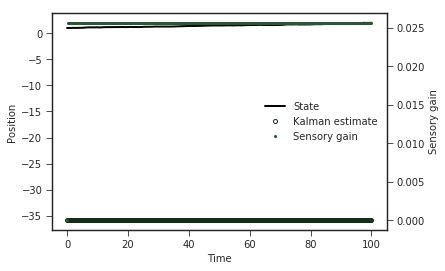

In [182]:
## Kalman network test: initial state only
# initial state
state = neurkal.StateDynamics(M, B, Z, x0=d_th[0])

# network initialization
sensory_input = neurkal.PopCode(p, space=th_r, act_func=input_act,
                                dist=np.random.poisson)
# motor_input = popcode.PopCode(p, act_func=input_act, dist=lambda x: x)
kalman_network = neurkal.KalmanBasisNetwork(sensory_inputs=[sensory_input],
                                            motor_inputs=[], M=M, B=-np.array(B))

states = []
estimates = []
gains = []

sensory_input(state.x[0])
for t in ts:
    states.append(state.x[0])
    gains.append(kalman_network.lam[0])
    # update activity in basis network implementing Kalman filter
    sigma = np.var(estimates[-10:]) if i > 10 else 1e12
    kalman_network.update(kalman.sigma)
    estimates.append(kalman_network.readout())
    # update real state (+ control noise)
    state.update(c_)
    if not t:
        sensory_input.clear()
    
palette = set_palette()
fig, ax1 = plt.subplots()#figsize=(7, 6))
ax1.set_xlabel("Time")
ax1.set_ylabel("Position")
p1, = ax1.plot(ts, states, '-', color=next(palette), label="State", lw=2)
p2, = ax1.plot(ts, estimates, '.', color=next(palette), label="Kalman estimate", markerfacecolor='none', ms=8)
ax2 = ax1.twinx()
ax2.set_ylabel("Sensory gain")
p3, = ax2.plot(ts, gains, '.', color=next(palette), label="Sensory gain", ms=4)

ps = [p1, p2, p3]
labels = [p.get_label() for p in ps]
ax1.legend(ps, labels, loc=7)
plt.show()

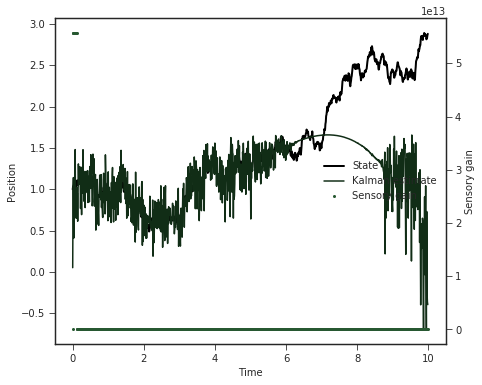

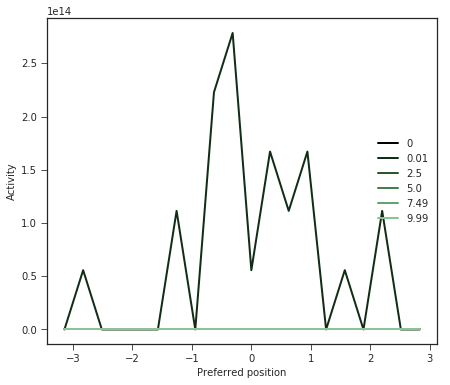

In [128]:
## Kalman network test: state estimates at each timestep
# initial state
x0 = 1
state = neurkal.StateDynamics(M, B, Z, x0=x0)

# network initialization
sensory_input = neurkal.PopCode(p, act_func=input_act,
                                dist=np.random.poisson)
# motor_input = popcode.PopCode(p, act_func=input_act, dist=lambda x: x)
kalman_network = neurkal.KalmanBasisNetwork(sensory_inputs=[sensory_input],
                                            motor_inputs=[], M=M, B=-np.array(B))

states = []
activities = []
estimates = []
gains = []

ts = np.arange(0, t_f, dt)
sensory_input(0.0)  # prior
for i, t in enumerate(ts):
    states.append(state.x[0])
    activities.append(np.copy(kalman_network.activity))
    network_estimate = kalman_network.readout()
    estimates.append(network_estimate)
    gains.append(kalman_network.lam[0])
    # update activity in basis network implementing Kalman filter
    sigma = np.var(estimates[-10:]) if i > 10 else 1e12
    kalman_network.update([[sigma]])
    
    # update real state (+ control noise)
    state.update(c_)
    sensory_input(state.x[0])
    
    
palette = set_palette()
fig, ax1 = plt.subplots(figsize=(7, 6))
ax1.set_xlabel("Time")
ax1.set_ylabel("Position")
p1, = ax1.plot(ts, states, '-', color=next(palette), label="State", lw=2)
p2, = ax1.plot(ts, estimates, '-', color=next(palette), label="Kalman estimate", markerfacecolor='none', ms=8)
ax2 = ax1.twinx()
ax2.set_ylabel("Sensory gain")
p3, = ax2.plot(ts[11:], gains[11:], '.', color=next(palette), label="Sensory gain", ms=4)

ps = [p1, p2, p3]
labels = [p.get_label() for p in ps]
ax1.legend(ps, labels, loc=7)
plt.show()

prefs = kalman_network.prefs
    
palette = set_palette()
fig, ax1 = plt.subplots(figsize=(7, 6))
ax1.set_xlabel("Preferred position")
ax1.set_ylabel("Activity")
ps = []
ps.append(ax1.plot(prefs, activities[0], '-', color=next(palette), lw=2, label="0")[0])
for i in np.linspace(1, int(t_f/dt) - 1, 5).tolist():
    ps.append(ax1.plot(prefs, activities[int(i)], '-', color=next(palette), lw=2, 
                       label=str(ts[int(i)]))[0])
    
labels = [p.get_label() for p in ps]
ax1.legend(ps, labels, loc=7)
plt.show()

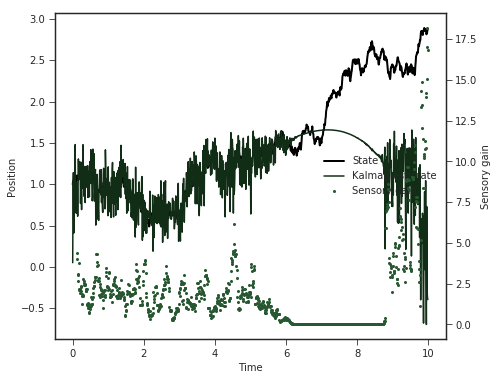

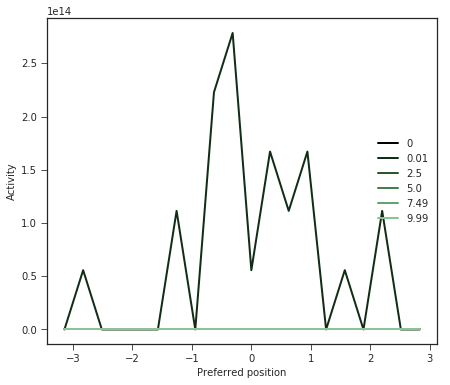

In [131]:
palette = set_palette()
fig, ax1 = plt.subplots(figsize=(7, 6))
ax1.set_xlabel("Time")
ax1.set_ylabel("Position")
p1, = ax1.plot(ts, states, '-', color=next(palette), label="State", lw=2)
p2, = ax1.plot(ts, estimates, '-', color=next(palette), label="Kalman estimate", markerfacecolor='none', ms=8)
ax2 = ax1.twinx()
ax2.set_ylabel("Sensory gain")
p3, = ax2.plot(ts[12:], gains[12:], '.', color=next(palette), label="Sensory gain", ms=4)

ps = [p1, p2, p3]
labels = [p.get_label() for p in ps]
ax1.legend(ps, labels, loc=7)
plt.show()

prefs = kalman_network.prefs
    
palette = set_palette()
fig, ax1 = plt.subplots(figsize=(7, 6))
ax1.set_xlabel("Preferred position")
ax1.set_ylabel("Activity")
ps = []
ps.append(ax1.plot(prefs, activities[0], '-', color=next(palette), lw=2, label="0")[0])
for i in np.linspace(1, int(t_f/dt) - 1, 5).tolist():
    ps.append(ax1.plot(prefs, activities[int(i)], '-', color=next(palette), lw=2, 
                       label=str(ts[int(i)]))[0])
    
labels = [p.get_label() for p in ps]
ax1.legend(ps, labels, loc=7)
plt.show()